In [17]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
import torch

from torch.utils.data import (TensorDataset, DataLoader,
                              RandomSampler, SequentialSampler)

from transformers import BertTokenizer, BertConfig, RobertaTokenizerFast
from transformers import BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup

from distutils.version import LooseVersion as LV

from sklearn.model_selection import train_test_split

import io

import pandas as pd
import numpy as np

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [19]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    devicename = '['+torch.cuda.get_device_name(0)+']'
else:
    device = torch.device('cpu')
    devicename = ""
    
print('Using PyTorch version:', torch.__version__,
      'Device:', device, devicename)
assert(LV(torch.__version__) >= LV("1.0.0"))

Using PyTorch version: 1.12.1+cu113 Device: cuda [Tesla T4]


#Loading the multilingual dataset

In [20]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
df_ml = pd.read_csv('/content/drive/MyDrive/Progetto_TA_2022/df_tot.csv')

In [22]:
df_ml.shape

(290183, 5)

In [23]:
df_ml.head()

,Artist,Song,Genre,Language,Lyrics
0,12 stones,world so cold,Rock,en,"It starts with pain, followed by hate\nFueled ..."
1,12 stones,broken,Rock,en,Freedom!\nAlone again again alone\nPatiently w...
2,12 stones,3 leaf loser,Rock,en,"Biting the hand that feeds you, lying to the v..."
3,12 stones,anthem for the underdog,Rock,en,You say you know just who I am\nBut you can't ...
4,12 stones,adrenaline,Rock,en,My heart is beating faster can't control these...


In [24]:
df_ml['Language'].value_counts() #Genre distribution in training set

en    250197
pt     30102
es      3892
ro      1184
it       808
id       737
fr       644
de       478
sw       304
tl       241
so       229
cy       226
ca       137
tr       116
nl       116
sk        98
hr        97
no        93
sl        77
af        77
da        71
sv        61
et        58
fi        54
pl        24
cs        17
sq        15
hu        10
vi         7
ru         4
lt         2
lv         2
ko         1
Name: Language, dtype: int64

In [25]:
df_ml['Genre'].isnull().values.any() #Checking the Genre column on having all valid records

False

In [26]:
df_ml['Language'].isnull().values.any()

True

In [27]:
df_ml['Lyrics'].isnull().values.any()

True

In [28]:
df_ml.dropna(subset = ['Language'], inplace=True) #eliminating the rows with NaN values in Language and Lyrics 


In [29]:
df_ml.dropna(subset = ['Lyrics'], inplace=True)

In [30]:
df_ml = df_ml.reset_index()
df_ml = df_ml.drop(['index'], axis = 1)

In [31]:
df_ml.shape

(290144, 5)

In [32]:
df_ml = df_ml.reset_index()
df_ml = df_ml.drop(['index'], axis = 1)

In [33]:
df_ml.head()

,Artist,Song,Genre,Language,Lyrics
0,12 stones,world so cold,Rock,en,"It starts with pain, followed by hate\nFueled ..."
1,12 stones,broken,Rock,en,Freedom!\nAlone again again alone\nPatiently w...
2,12 stones,3 leaf loser,Rock,en,"Biting the hand that feeds you, lying to the v..."
3,12 stones,anthem for the underdog,Rock,en,You say you know just who I am\nBut you can't ...
4,12 stones,adrenaline,Rock,en,My heart is beating faster can't control these...


Creating a 3 language dataset (most frequent)

In [34]:
most_frequent_languages=['en', 'pt', 'es']
df_ml_3 = df_ml[df_ml['Language'].isin(most_frequent_languages)]

In [35]:
labels = df_ml_3['Language'].unique()

In [36]:
plt.rcParams["figure.figsize"] = [12,8]
colors = ['#05c9f0', '#00f6fa', '#6f8eec']
plt.pie(df_ml_3['Language'].value_counts(), labels =labels, autopct = '%1.1f%%',colors = colors, shadow = True)
plt.title('Language Distribution')

Text(0.5, 1.0, 'Language Distribution')

#Splitting the dataset in training set and test set

In [37]:
import sklearn
from sklearn.model_selection import train_test_split

In [38]:
ml_train, ml_test = sklearn.model_selection.train_test_split(df_ml_3, test_size=0.20, train_size=0.80)

In [39]:
ml_train.shape, ml_test.shape

((227352, 5), (56839, 5))

In [40]:
x_train = ml_train['Lyrics']
y_train = ml_train['Genre']

x_test = ml_test['Lyrics']
y_test = ml_test['Genre']

#Generating numerical labels

In [41]:
import numpy as np

label_map = {label:idx for idx,label in enumerate(sorted(set(y_train)))}
print(label_map)

y_train_vect = np.asarray([label_map[label] for label in y_train])
y_test_vect = np.asarray([label_map[label] for label in y_test])

y_train_vect,y_test_vect

{'Country': 0, 'Electronic': 1, 'Folk': 2, 'Hip-Hop': 3, 'Indie': 4, 'Jazz': 5, 'Metal': 6, 'Pop': 7, 'R&B': 8, 'Rock': 9}


(array([4, 9, 9, ..., 9, 9, 9]), array([7, 7, 5, ..., 3, 7, 6]))

#Text Pre-processing 

In [42]:
sentences_train = ["[CLS] " + s for s in x_train]
sentences_test = ["[CLS] " + s for s in x_test]
labels_train = y_train_vect
labels_test  = y_test_vect

In [43]:
from transformers import BertModel
BERTMODEL = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(BERTMODEL)
model = BertModel.from_pretrained(BERTMODEL)

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [44]:
from tqdm import tqdm

tokenized_train = [tokenizer.tokenize(s) for s in tqdm(sentences_train)]
tokenized_test  = [tokenizer.tokenize(s) for s in tqdm(sentences_test)]

100%|██████████| 56839/56839 [03:09<00:00, 299.73it/s]


In [45]:
MAX_LEN_TRAIN, MAX_LEN_TEST = 128, 512

tokenized_train = [t[:(MAX_LEN_TRAIN-1)]+['SEP'] for t in tokenized_train]
tokenized_test  = [t[:(MAX_LEN_TEST-1)]+['SEP'] for t in tokenized_test]

print ("The truncated tokenized first training sentence:")
print (tokenized_train[0])

The truncated tokenized first training sentence:
['[CLS]', 'Your', 'sm', '##ile', 'is', 'like', 'the', 'sun', 'to', 'me', 'So', 'bright', 'it', '?', 's', 'weak', '##ening', 'But', 'so', 'sweet', 'But', 'of', 'all', 'that', 'you', "'", 'd', 'like', 'from', 'me', 'A', 'sm', '##ile', 'and', 'be', 'oka', '##y', 'Sorry', 'It', '?', 's', 'taken', 'me', 'every', '##day', 'To', 'accept', 'that', 'I', 'have', 'to', 'say', 'Say', 'no', 'I', '?', 'll', 'be', 'right', 'here', '(', 'Say', 'something', "'", 's', 'wrong', ')', '(', 'To', 'just', 'find', 'fault', ')', 'She', 'com', '##plain', '##s', 'the', 'room', '?', 's', 'too', 'cold', '(', 'But', 'when', 'I', 'learn', 'to', 'make', 'heat', ',', ')', 'It', "'", 's', 'just', 'to', 'disa', '##ppo', '##int', 'Oh', 'you', 'know', 'I', '?', 'll', 'for', '##get', '.', '.', '.', 'So', 'quick', 'Time', ',', 'It', 'makes', 'it', 'fine', 'That', '?', 's', 'how', 'we', 'make', 'this', 'SEP']


In [46]:
ids_train = [tokenizer.convert_tokens_to_ids(t) for t in tokenized_train]
ids_train = np.array([np.pad(i, (0, MAX_LEN_TRAIN-len(i)),
                             mode='constant') for i in ids_train])

ids_test = [tokenizer.convert_tokens_to_ids(t) for t in tokenized_test]
ids_test = np.array([np.pad(i, (0, MAX_LEN_TEST-len(i)),
                            mode='constant') for i in ids_test])

print ("The indices of the first training sentence:")
print (ids_train[0])

The indices of the first training sentence:
[   101  13554  39709  12808  10124  11850  10105  42230  10114  10911
  12882  72041  10271    136    187  61285  24428  16976  10380  72711
  16976  10108  10435  10189  13028    112    172  11850  10188  10911
    138  39709  12808  10111  10347  77146  10157  98314  10377    136
    187  15109  10911  14234  24558  11469  45218  10189    146  10529
  10114  23763  24625  10192    146    136  22469  10347  13448  19353
    113  24625  26133    112    187  56126    114    113  11469  12820
  17860 110640    114  11149  10212  88975  10107  10105  19555    136
    187  16683  41626    113  16976  10841    146  42671  10114  13086
  33955    117    114  10377    112    187  12820  10114  36474  45565
  16261  22800  13028  21852    146    136  22469  10142  14908    119
    119    119  12882  69609  12000    117  10377  20562  10271  13435
  13646    136    187  14796  11951  13086  10531    100]


In [47]:
amasks_train, amasks_test = [], []

for seq in ids_train:
  seq_mask = [float(i>0) for i in seq]
  amasks_train.append(seq_mask)

for seq in ids_test:
  seq_mask = [float(i>0) for i in seq]
  amasks_test.append(seq_mask)

In [48]:
(train_inputs, validation_inputs,
 train_labels, validation_labels) = train_test_split(ids_train, labels_train,
                                                     random_state=42, test_size=0.1)
 

(train_masks, validation_masks,
 _, _) = train_test_split(amasks_train, ids_train,
                          random_state=42, test_size=0.1)

train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks  = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks  = torch.tensor(validation_masks)
test_inputs = torch.tensor(ids_test)
test_labels = torch.tensor(labels_test)
test_masks  = torch.tensor(amasks_test)

In [49]:
BATCH_SIZE = 32

print('Datasets:')
print('Train: ', end="")
train_data = TensorDataset(train_inputs, train_masks,
                           train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler,
                              batch_size=BATCH_SIZE)
print(len(train_data), 'documents')

print('Validation: ', end="")
validation_data = TensorDataset(validation_inputs, validation_masks,
                                validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data,
                                   sampler=validation_sampler,
                                   batch_size=BATCH_SIZE)
print(len(validation_data), 'documents')

print('Test: ', end="")
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler,
                             batch_size=BATCH_SIZE)
print(len(test_data), 'documents')

Datasets:
Train: 204616 documents
Validation: 22736 documents
Test: 56839 documents


In [50]:
ml_train.shape, ml_test.shape

((227352, 5), (56839, 5))

In [51]:
x_train = ml_train['Lyrics']
y_train = ml_train['Genre']

x_test = ml_test['Lyrics']
y_test = ml_test['Genre']

#BERT model initialization

---



---



In [52]:
model = BertForSequenceClassification.from_pretrained(BERTMODEL,
                                                      num_labels=len(label_map))
model.cuda()
print('Pretrained BERT model "{}" loaded'.format(BERTMODEL))

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

Pretrained BERT model "bert-base-multilingual-cased" loaded


In [53]:
#We set the remaining hyperparameters needed for fine-tuning the pretrained model:
#EPOCHS: the number of training epochs in fine-tuning (recommended values between 2 and 4)
#WEIGHT_DECAY: weight decay for the Adam optimizer
#LR: learning rate for the Adam optimizer (2e-5 to 5e-5 recommended)
#WARMUP_STEPS: number of warmup steps to (linearly) reach the set learning rate
#We also need to grab the training parameters from the pretrained model.

In [54]:
EPOCHS = 3
WEIGHT_DECAY = 0.01
LR = 2e-5
WARMUP_STEPS =int(0.2*len(train_dataloader))

no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters()
                if not any(nd in n for nd in no_decay)],
     'weight_decay': WEIGHT_DECAY},
    {'params': [p for n, p in model.named_parameters()
                if any(nd in n for nd in no_decay)],
     'weight_decay': 0.0}
]
optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=LR, eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=WARMUP_STEPS,
                                 num_training_steps =len(train_dataloader)*EPOCHS)

#Training
Definitions of functions to train and evaluate the model

In [55]:
def train(epoch, loss_vector=None, log_interval=200):
  # Set model to training mode
  model.train()

  # Loop over each batch from the training set
  for step, batch in enumerate(train_dataloader):

    # Copy data to GPU if needed
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Zero gradient buffers
    optimizer.zero_grad()

    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None,
                    attention_mask=b_input_mask, labels=b_labels)

    loss = outputs[0]
    if loss_vector is not None:
        loss_vector.append(loss.item())

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()
    scheduler.step()

    if step % log_interval == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, step * len(b_input_ids),
                len(train_dataloader.dataset),
                100. * step / len(train_dataloader), loss))

from sklearn.metrics import confusion_matrix, classification_report

def evaluate(loader):
  model.eval()

  n_correct, n_all = 0, 0

  predicted_labels = list()
  true_labels = list()

  for batch in loader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)
      logits = outputs[0]

    logits = logits.detach().cpu().numpy()
    predictions = np.argmax(logits, axis=1)

    labels = b_labels.to('cpu').numpy()
    n_correct += np.sum(predictions == labels)

    true_labels.extend(labels)
    predicted_labels.extend(predictions)
    n_all += len(labels)

  print('Accuracy: [{}/{}] {:.4f}'.format(n_correct, n_all,
                                          n_correct/n_all))
  print('Classification report:')
  print(classification_report(true_labels, predicted_labels,target_names=[x[0] for x in sorted(label_map.items(),key=lambda x:x[1])]))
  print('Confusion matrix:')
  cm = confusion_matrix(true_labels, predicted_labels)
  print(cm)

In [56]:
train_lossv = []
for epoch in range(1, EPOCHS + 1):
    print()
    train(epoch, train_lossv)
    print('\nValidation set:')
    evaluate(validation_dataloader)


Train Epoch: 1 [0/204616 (0%)]	Loss: 2.167026
Train Epoch: 1 [6400/204616 (3%)]	Loss: 1.477939
Train Epoch: 1 [12800/204616 (6%)]	Loss: 1.364785
Train Epoch: 1 [19200/204616 (9%)]	Loss: 1.514669
Train Epoch: 1 [25600/204616 (13%)]	Loss: 1.074351
Train Epoch: 1 [32000/204616 (16%)]	Loss: 1.391226
Train Epoch: 1 [38400/204616 (19%)]	Loss: 0.945563
Train Epoch: 1 [44800/204616 (22%)]	Loss: 1.081318
Train Epoch: 1 [51200/204616 (25%)]	Loss: 0.960018
Train Epoch: 1 [57600/204616 (28%)]	Loss: 1.030968
Train Epoch: 1 [64000/204616 (31%)]	Loss: 1.239675
Train Epoch: 1 [70400/204616 (34%)]	Loss: 1.271374
Train Epoch: 1 [76800/204616 (38%)]	Loss: 1.408420
Train Epoch: 1 [83200/204616 (41%)]	Loss: 0.767961
Train Epoch: 1 [89600/204616 (44%)]	Loss: 1.063429
Train Epoch: 1 [96000/204616 (47%)]	Loss: 1.275719
Train Epoch: 1 [102400/204616 (50%)]	Loss: 0.992606
Train Epoch: 1 [108800/204616 (53%)]	Loss: 0.914981
Train Epoch: 1 [115200/204616 (56%)]	Loss: 1.187675
Train Epoch: 1 [121600/204616 (59%)]

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Epoch: 2 [0/204616 (0%)]	Loss: 0.968696
Train Epoch: 2 [6400/204616 (3%)]	Loss: 0.885466
Train Epoch: 2 [12800/204616 (6%)]	Loss: 1.329259
Train Epoch: 2 [19200/204616 (9%)]	Loss: 0.830199
Train Epoch: 2 [25600/204616 (13%)]	Loss: 1.056454
Train Epoch: 2 [32000/204616 (16%)]	Loss: 0.878954
Train Epoch: 2 [38400/204616 (19%)]	Loss: 0.751379
Train Epoch: 2 [44800/204616 (22%)]	Loss: 1.056209
Train Epoch: 2 [51200/204616 (25%)]	Loss: 0.874985
Train Epoch: 2 [57600/204616 (28%)]	Loss: 1.355772
Train Epoch: 2 [64000/204616 (31%)]	Loss: 0.720481
Train Epoch: 2 [70400/204616 (34%)]	Loss: 1.020140
Train Epoch: 2 [76800/204616 (38%)]	Loss: 0.856954
Train Epoch: 2 [83200/204616 (41%)]	Loss: 0.957652
Train Epoch: 2 [89600/204616 (44%)]	Loss: 0.687129
Train Epoch: 2 [96000/204616 (47%)]	Loss: 1.152386
Train Epoch: 2 [102400/204616 (50%)]	Loss: 1.027489
Train Epoch: 2 [108800/204616 (53%)]	Loss: 0.804251
Train Epoch: 2 [115200/204616 (56%)]	Loss: 0.856515
Train Epoch: 2 [121600/204616 (59%)]	

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Epoch: 3 [0/204616 (0%)]	Loss: 0.863817
Train Epoch: 3 [6400/204616 (3%)]	Loss: 0.958281
Train Epoch: 3 [12800/204616 (6%)]	Loss: 0.570623
Train Epoch: 3 [19200/204616 (9%)]	Loss: 0.839519
Train Epoch: 3 [25600/204616 (13%)]	Loss: 1.034386
Train Epoch: 3 [32000/204616 (16%)]	Loss: 0.974608
Train Epoch: 3 [38400/204616 (19%)]	Loss: 1.090598
Train Epoch: 3 [44800/204616 (22%)]	Loss: 0.994619
Train Epoch: 3 [51200/204616 (25%)]	Loss: 0.637991
Train Epoch: 3 [57600/204616 (28%)]	Loss: 0.780881
Train Epoch: 3 [64000/204616 (31%)]	Loss: 0.997100
Train Epoch: 3 [70400/204616 (34%)]	Loss: 1.113252
Train Epoch: 3 [76800/204616 (38%)]	Loss: 1.306252
Train Epoch: 3 [83200/204616 (41%)]	Loss: 0.856392
Train Epoch: 3 [89600/204616 (44%)]	Loss: 0.921093
Train Epoch: 3 [96000/204616 (47%)]	Loss: 0.689576
Train Epoch: 3 [102400/204616 (50%)]	Loss: 1.073944
Train Epoch: 3 [108800/204616 (53%)]	Loss: 1.055163
Train Epoch: 3 [115200/204616 (56%)]	Loss: 0.987123
Train Epoch: 3 [121600/204616 (59%)]	

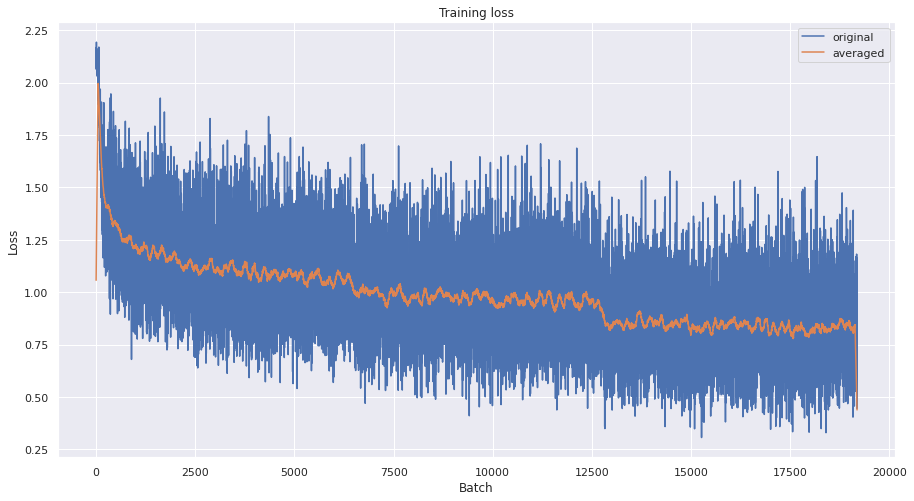

In [57]:
%matplotlib inline
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_lossv, label='original')
plt.plot(np.convolve(train_lossv, np.ones(101), 'same') / 101,
         label='averaged')
plt.legend(loc='best')
plt.show()

Evaluation

In [58]:
print('Test set:')
evaluate(test_dataloader)

Test set:
Accuracy: [37822/56839] 0.6654
Classification report:
              precision    recall  f1-score   support

     Country       0.57      0.05      0.10       393
  Electronic       0.11      0.00      0.00       446
        Folk       0.50      0.09      0.15      1712
     Hip-Hop       0.37      0.02      0.05       452
       Indie       0.49      0.02      0.04      1690
        Jazz       0.74      0.54      0.63      2643
       Metal       0.73      0.43      0.54      3968
         Pop       0.75      0.66      0.70     20913
         R&B       0.93      0.02      0.05       572
        Rock       0.61      0.86      0.72     24050

    accuracy                           0.67     56839
   macro avg       0.58      0.27      0.30     56839
weighted avg       0.67      0.67      0.63     56839

Confusion matrix:
[[   21     0     7     0     0     3     0    28     0   334]
 [    0     1     2     4     0     3    23   162     1   250]
 [    2     0   152     0     5  